# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [29]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [30]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [31]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [32]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

1.0


In [33]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [34]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [35]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

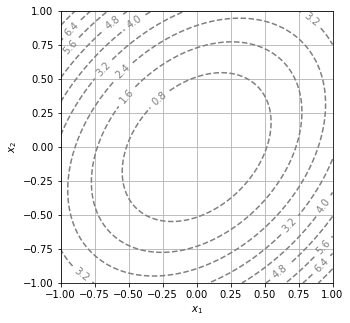

In [36]:
display_contour(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = 10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [37]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

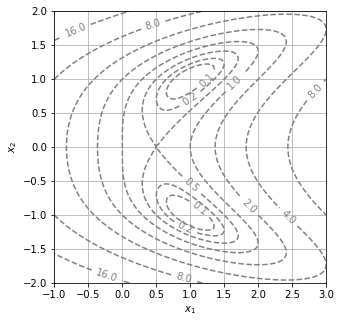

In [38]:
display_contour(
    f2, 
    x = np.linspace(-1.0, 3.0, 100), 
    y = np.linspace(-2.0, 2.0, 100), 
    levels = [2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [39]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

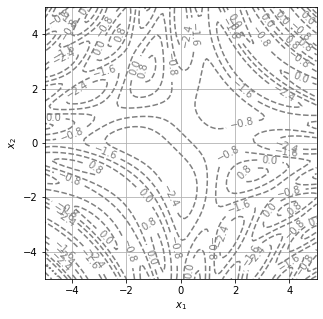

In [40]:
display_contour(
    f3, 
    x = np.linspace(-5.0, 5.0, 100), 
    y = np.linspace(-5.0, 5.0, 100), 
    levels = 5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [41]:
N = 1000
eps = 1e-5

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [42]:
def Newton(F, x0, y0, eps = eps, N = N):
    x0, y0 = float(x0), float(y0) 
    for i in range(N):
        Q = J(F)(x0, y0)
        (x, y) = (x0, y0) - np.dot(np.linalg.inv(Q),F(x0, y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

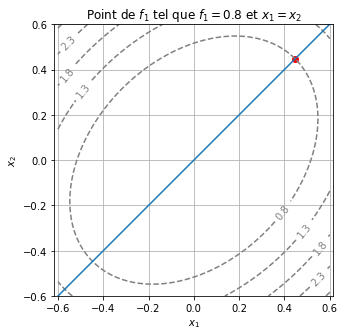

In [43]:
def f1_egalitaire(x, y):
    vect = (f1(x, y) - 0.8, x - y)
    vecto = np.array(vect)
    return vecto

n1 = Newton(f1_egalitaire, 0.8, 0.8)
X = list(n1)
display_contour(
    f1, 
    x = np.linspace(-0.6, 0.6, 100), 
    y = np.linspace(-0.6, 0.6, 100), 
    levels = [0.8] + np.linspace(0, 5, 11)
)
plt.scatter(X[0], X[1], c ='r')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Point de $f_1$ tel que $f_1=0.8$ et $x_1=x_2$")
plt.grid(True)
plt.axis("equal")

L = np.linspace(-0.6, 0.6, 100)
plt.plot(L, L)
plt.show()

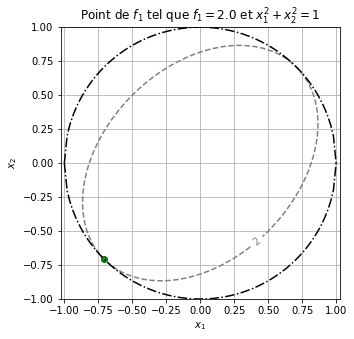

In [44]:
def f1_sommunit(x, y):
    vect = (f1(x, y) - 2.0, x**2 + y**2 - 1)
    vecto = np.array(vect)
    return vecto

n2 = Newton(f1_sommunit,0.0,-0.3)
X = list(n2)
display_contour(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = [2.0] 
)
plt.scatter(X[0], X[1], c ='g')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Point de $f_1$ tel que $f_1=2.0$ et $x_1^{2}+x_2^{2}=1$")
plt.grid(True)
plt.axis("equal")

def cerclunithaut(x):
    return np.sqrt(1 - x**2)

def cerclunitbas(x):
    return -np.sqrt(1 - x**2)

M = np.linspace(-1, 1, 100)
plt.plot(M,cerclunithaut(M), linestyle = "-.", c = 'k')
plt.plot(M,cerclunitbas(M), linestyle = "-.", c = 'k')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

**Réponse** : On peut utiliser une méthode de Newton modifiée qui ajoute en plus comme contrainte que l'on renvoie $(x,y)$ seulement si celui-ci est à une distance $\delta > 0$ de $(x_0, y_0)$, c'est à dire que l'on veut qu'en plus $|\|(x, y) - (x_0, y_0)\| - \delta | \leq \varepsilon$ où $\varepsilon$ est l'epsilon machine. On ajoute ensuite la condition que de plus on doit avoir le point "à droite", c'est à dire qu'avec ce que l'on a défini plus haut,   $p(x_1, y_1) > 0$. Implémentons cela à présent !

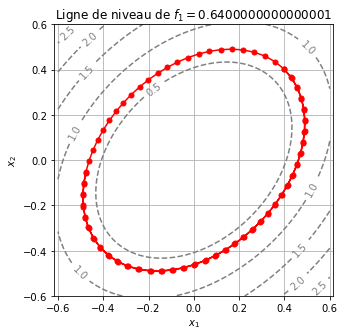

In [45]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    g = autograd.grad
    coord = np.zeros((2, N))
    coord[0, 0], coord[1, 0] = x0, y0
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c, 0)(x0, y0)**2 + g(f_c, 1)(x0, y0)**2), (g(f_c, 1)(x0, y0), -g(f_c, 0)(x0, y0)))
        a, b = x0, y0
        def F(x, y):
            vecti = np.array([
                f_c(x, y),
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            return vecti
        (x0, y0) = (x0, y0) + np.dot(delta, vect)        
        x, y = Newton(F, x0, y0)
        coord[0, i], coord[1, i] = x, y
        x0, y0 = x, y
    return coord



X = level_curve(f1,0.4,0.4,0.05,100)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels=np.linspace(0,5,11)
)
plt.plot(X[0],X[1],c='r',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_1={f1(0.4,0.4)}$")
plt.grid(True)
plt.axis("equal")

plt.show()

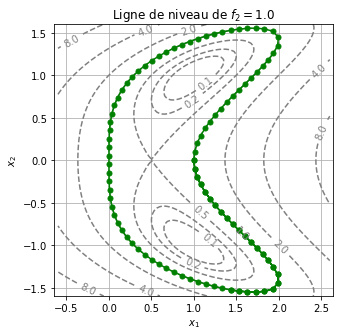

In [46]:
def f2_egalitaire(x1, x2):
    vect = np.array((f2(x1, x2) - 1.0,x1-x2))
    return vect

def f2_modif(x1,x2):
    return f2_egalitaire(x1,x2)[0]

start = (1.0,0.0)
X = level_curve(f2,start[0],start[1],0.1,120)
display_contour(
    f2, 
    x=np.linspace(-0.6, 2.6, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels= [2**i for i in range(-3, 8)] 
)
plt.plot(X[0],X[1],c='g',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_2={f2(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

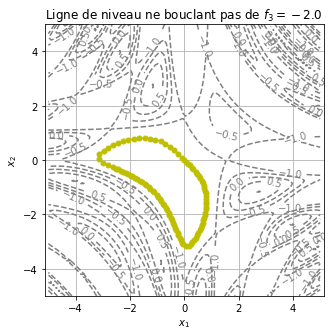

In [47]:
start = (0.0,0.0)
X = level_curve(f3,start[0],start[1],0.2,100)
display_contour(
    f3, 
    x=np.linspace(-5, 5, 100), 
    y=np.linspace(-5, 5, 100), 
    levels= np.linspace(-1,1,5)
)
plt.plot(X[0],X[1],c='y',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau ne bouclant pas de $f_3={f3(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [48]:
def level_curve_inter(f, x0, y0, delta = 0.001, N = 1000, eps = eps):
    g = autograd.grad
    coord = np.zeros((2, N))
    coord[0,0], coord[1,0] = x0, y0
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c, 0)(x0, y0)**2 + g(f_c, 1)(x0, y0)**2), (g(f_c, 1)(x0, y0), -g(f_c, 0)(x0, y0)))
        a, b = x0, y0
        def F(x, y):
            vecti = np.array([
                f_c(x, y),
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            return vecti
        (x0, y0) = (x0, y0) + np.dot(delta, vect)        
        x, y = Newton(F, x0, y0)
        x0, y0 = x, y
        coord[0,i], coord[1,i] = x, y
        if i >= 2:
            for k in range(0, i-1):
                segm1 = np.array((coord[0, k + 1] - coord[0, k], coord[1, k + 1] - coord[1, k]))
                segm2 = np.array((coord[0, i] - coord[0, k], coord[1, i] - coord[1, k]))
                cross = np.cross(segm1, segm2)
                if np.linalg.norm(cross) <= delta/10 and np.linalg.norm(segm1) >= np.linalg.norm(segm2) and np.dot(segm1, segm2) > 0:
                    return coord[::,0:i]
    return coord



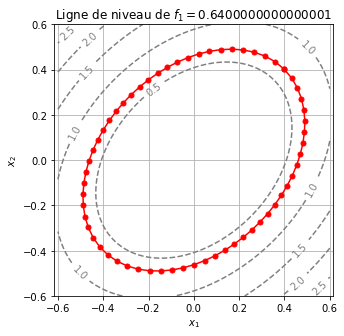

In [49]:
x0,y0 = (0.4,0.4)
X = level_curve_inter(f1,x0,y0,0.05,100)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= np.linspace(0,5,11)
)
plt.plot(X[0],X[1],c='r',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_1={f1(x0,y0)}$")
plt.grid(True)
plt.axis("equal")
plt.show()

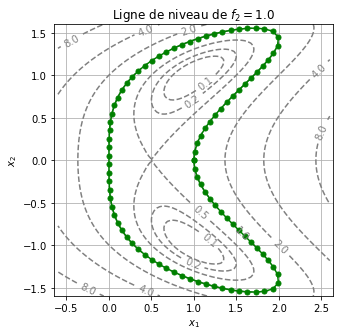

In [50]:
start = (1.0,0.0)
X = level_curve_inter(f2,start[0],start[1],0.1,150)
display_contour(
    f2, 
    x=np.linspace(-0.6, 2.6, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels= [2**i for i in range(-3, 8)] 
)
plt.plot(X[0],X[1],c='g',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_2={f2(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

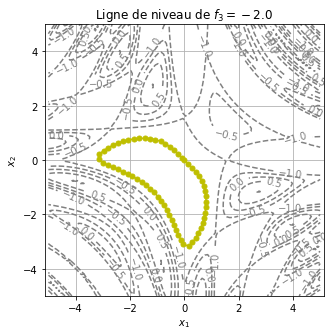

In [51]:
start = (0.0,0.0)
X = level_curve_inter(f3,start[0],start[1],0.2,100)
display_contour(
    f3, 
    x=np.linspace(-5, 5, 100), 
    y=np.linspace(-5, 5, 100), 
    levels= np.linspace(-1,1,5)
)
plt.plot(X[0],X[1],c='y',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_3={f3(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [52]:
from numpy import math

def area_squares(f, x0, y0, h, delta = 0.01, N = 100, eps = eps):
    c = f(x0, y0)
    X, Y = level_curve_inter(f, x0, y0, delta, N, eps)
    x_min = min(X)
    x_max = max(X)
    y_min = min(Y)
    y_max = max(Y)
    L = x_max - x_min
    L = (L//h + 1)*h
    l = y_max - y_min
    l = (l//h + 1)*h
    d = max(L, l)     
    n = int(d/h) 
    S = 0
    aire = h**2
    for i in range (0, n + 1):
        for j in range (0, n + 1):
            x = x_min + (i + 0.5)*h
            y = y_min + (j + 0.5)*h
            if (f(x, y) <= c) :
                S = S + aire 
    return S


def norme_carre(x, y):
    return (x**2 + y**2)

print(area_squares(norme_carre, 1.0, 0.0, 0.001, 0.1, 100, 0.01), math.pi)

3.1415450000852143 3.141592653589793


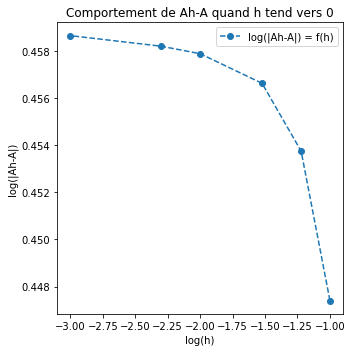

In [53]:
A = math.pi

def A_h(x):
    return area_squares(norme_carre, 1.0, 0.0, x, 0.01, 100, 0.01)

H = [0.1, 0.06, 0.03, 0.01, 0.005, 0.001]

tab = []
for x in H :
    tab = tab + [abs(A - A_h(x))]


plt.plot(np.log10(H), np.log10(tab), 'o--', label = 'log(|Ah-A|) = f(h)')
plt.title("Comportement de Ah-A quand h tend vers 0")
plt.xlabel('log(h)')
plt.ylabel('log(|Ah-A|)')
plt.legend()
plt.tight_layout()
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


**Réponse** Pour obtenir un encardement à $10^{-2}$ près, on utilise la même méthode que area_squares mais à la place de vérifier que le centre de chaque petit carré appartient à l'ensemble on vérifie les sommets de chaque petit carré ($h^{2}$).
Si tout les sommets du petit carré ($h^{2}$) appartiennent à l'ensemble, alors il vérifie le critère minimum et on prend en compte son aire pour minorer l'aire réelle.
D'autres part, si au minimum un sommet du petit carré ($h^{2}$) appartient à l'ensemble, alors il vérifie le critère maximum et on prend en compte son aire pour majorer l'aire réelle.

In [56]:
def condition(f, c, i, j, h):
    t = 0
    x = x_min + i*h
    y = y_min + j*h
    if (f(x, y) <= c) :
        t = t + 1
    x = x_min + i*h
    y = y_min + (j + 1)*h
    if (f(x, y) <= c) :
        t = t + 1
    x = x_min + (i + 1)*h
    y = y_min + j*h
    if (f(x, y) <= c) :
        t = t + 1
    x = x_min + (i + 1)*h
    y = y_min + (j + 1)*h
    if (f(x, y) <= c) :
        t = t + 1
    return t


def area_squares_encadrement(f, x0, y0, h, delta = 0.01, N = 100, eps = eps):
    c = f(x0, y0)
    X, Y = level_curve_inter(f, x0, y0, delta, N, eps)
    x_min = min(X)
    x_max = max(X)
    y_min = min(Y)
    y_max = max(Y)
    L = x_max - x_min
    L = (L//h + 1)*h
    l = y_max - y_min
    l = (l//h + 1)*h
    d = max(L, l)     
    n = int(d/h) 
    S_min = 0
    S_max = 0
    aire = h**2
    for i in range (0, n + 1):
        for j in range (0, n + 1):
            if condition(f, c, i, j, h) == 4 :
                S_min = S_min + aire
            if condition(f, c, i, j, h) >= 1 :
                S_max = S_max + aire
            x = x_min + (i + 0.5)*h
            y = y_min + (j + 0.5)*h
    return S_min, S_max

print(area_squares_encadrement(norme_carre, 1.0, 0.0, 0.001, 0.1, 100, 0.01), math.pi)
# on obtient bien un résultat cohérent pour le disque unité

NameError: name 'x_min' is not defined

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [57]:
def contour_disque(centre, N) :
    disque = []
    for i in range (0, N) :
        x0, y0 = centre
        x = math.cos(2*i*math.pi/N) + x0
        y = math.sin(2*i*math.pi/N) + y0
        disque.append([x, y])
    return disque


def aire(point, contour) : 
    S = 0
    N = len(contour)
    x0, y0 =  point
    for i in range (0, N) :
        x1 = x0 - contour[i][0]
        y1 = y0 - contour[i][1]
        if i == N - 1 :
            x2 = x0 - contour[0][0]
            y2 = y0 - contour[0][1]
        else :
            x2 = x0 - contour[i + 1][0]
            y2 = y0 - contour[i + 1][1]
        M = np.array([[x1, y1], [x2, y2]])
        S = S + (np.linalg.det(M)/2)
    return S


print(aire([0, 0], contour_disque([0, 0], 1000)), math.pi)


3.1415719827794293 3.141592653589793


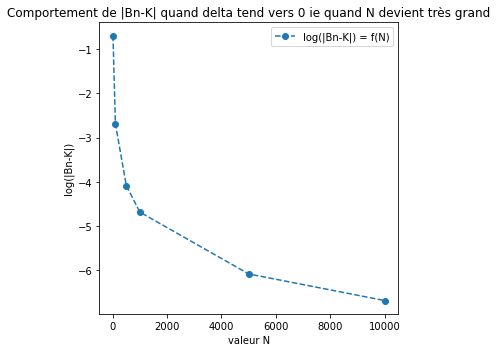

In [58]:
K = math.pi
valeur_N = [10, 100, 500, 1000, 5000, 10000]
tab = []

def B_n(x):
    contour = contour_disque([0, 0], x)
    return(aire([0, 0], contour))

valeur_N = [10, 100, 500, 1000, 5000, 10000]
for x in valeur_N:
    tab = tab + [abs(K - B_n(x))]

          
plt.plot(valeur_N, np.log10(tab), 'o--', label = 'log(|Bn-K|) = f(N)')
plt.title("Comportement de |Bn-K| quand delta tend vers 0 ie quand N devient très grand")
plt.xlabel('valeur N')
plt.ylabel('log(|Bn-K|)')
plt.legend()
plt.tight_layout()
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [59]:
contour = contour_disque([0, 0], 1000)
point = [4, 0]
print(aire(point, contour), math.pi)

3.1415719827794732 3.141592653589793


**Réponse :** On observe alors que l'aire calculée correspond bien à ce que nous voulions trouver.
En effet, cela s'explique par un phénomène de "télescopage": on peut tout d'abord diviser en deux groupes distincts les aires $A_i = A(p, z_i, z_{i+1})$, selon qu'elles soient positives ou négatives. Ensuite, on remarque une compensation: les aires négatives vont soustraire les surfaces en dehors de $K$, ne touchant presque pas (pour un $\delta$ proche de 0) notre ensemble $K$. Or les aires positives vont englober $K$ et aussi prendre en compte les aires en dehors de $K$, qui sont en réalité les aires négatives. En faisant la somme des $A_i$, on retrouve alors notre aire $A$ souhaitée, qui est celle de l'ensemble $K$.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [60]:
contour = contour_disque([0, 0], 1000) + contour_disque([3, 3], 1000)
print(aire([4, 4], contour), 2*math.pi) 

6.283143965558966 6.283185307179586


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [62]:
def area_triangles(f, x0 = 0.0, y0 = 0.0, delta = 0.001, N = 1000, eps = eps):
    X, Y = level_curve_inter(f, x0, y0, delta, N, eps)
    contour = []
    n = len(X)
    for i in range (1, n + 1):
        contour.append([X[n-i], Y[n-i]])
    return aire([x0, y0], contour)

print([area_triangles(f1, 0.4, 0.4, 0.05, 100), area_squares(f1, 0.4, 0.4, 0.01, 0.05, 100)])
print([area_triangles(f2, 1.0, 0.0, 0.1, 150), area_squares(f2, 1.0, 0.0, 0.01, 0.1, 150)])
print([area_triangles(f3, 0.0, 0.0, 0.2, 100), area_squares(f3, 0.0, 0.0, 0.01, 0.2, 100)])
#le temps de calcul est un peu long, mais on obtient bien des résultats cohérents avec les deux méthodes de calcul!

[0.7095549864090376, 0.711499999999938]
[3.6674471744726067, 3.6747000000033303]
[7.036327919127061, 7.056799999996892]


**Réponse :** on constate que les résultats obtenus par les deux méthodes de calculs sont très rpoches, (égaux à $10^{-1}$ près). Cependant, la méthode de calcul par les triangles est plus rapide que la méthode des carrées. Cela s'explique par le fait que pour la méthode des carrées, afin d'avoir une précision importante, il est nécéssaire d'avoir un h assez faible. Cette condition sur h implique que le nombre de carrés qui forment le grand carré dans lequel est contenue l'aire à calculée est très important. En effet, le nombre de carré est propotionelle à $h^{-2}$. Or, pour chaque carrée, il faut effectuer le test : $f(x_1,x_2)\leq c$. Tandis que pour avoir une precision importante avec la méthode des triangles, il est nécéssaire d'avoir un N (dans la fonction level_curve) assez grand. Et le nombre d'opérations faites en utilisant la méthode des triangles est proportionnel à N. On comprend donc que la méthode des triangles est plus efficace. 